16×1 Matrix{ComplexF64}:
 -0.06256128506306446 + 0.16822904913394957im
  0.16572189943703583 - 0.044789303323948176im
   0.1656920100688772 + 0.04476307529753205im
 -0.06249428569198112 - 0.16811418133616654im
 0.009418084812079681 + 0.0766761582037141im
  0.13488714443635955 + 0.08011398688503962im
  0.13336844562919922 - 0.0814525240875337im
  0.01283067831834887 - 0.07081392448080473im
  0.01283067831835337 + 0.07081392448080949im
  0.13336844562920544 + 0.08145252408752732im
  0.13488714443635444 - 0.08011398688504787im
  0.00941808481207581 - 0.07667615820370884im
  -0.0624942856919749 + 0.16811418133617065im
  0.16569201006888548 - 0.044763075297543725im
  0.16572189943702864 + 0.04478930332393593im
 -0.06256128506307011 - 0.1682290491339449im

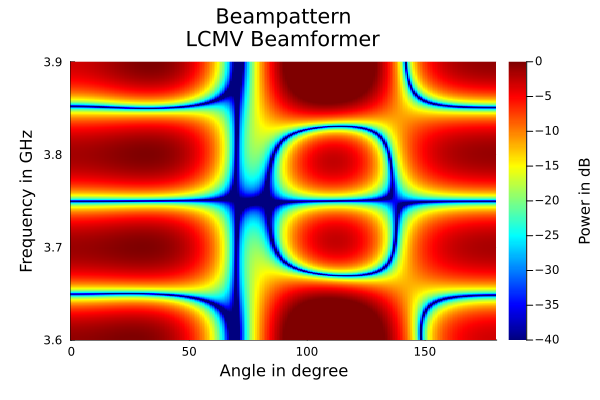

In [50]:
using ArraySignalProcessing
pa = TappedDelayLine(IsotropicArrayManifold(-6e-2, -2e-2, 2e-2, 6e-2), 4, 300e6)

# Use the array below to better see the behaviour
#pa = IsotropicArray(Vector(LinRange(-20e-2, 20e-2, 16)))

# Diagonal loading is applied by adding whitenoise to the correlation matrix
Snn = diffnoise(pa, 1e-6, 3.75e9) + whitenoise(pa, 1e-4)

# Constraints C set for two directions and 4 freqeuncy bands (as we set 4 taps)
C = steer(pa, deg2rad.([30 70]), [3.6e9, 3.7e9, 3.8e9, 3.9e9])

# Gains; four times repeated for the 4 frequencies
# the consstrains are set for
G = repeat([1, 0], 4, 1)

weights = lcmv_weights(Snn, C, G)
display(weights)

faxis = LinRange(3.6e9, 3.9e9, 1024)
ϕaxis = LinRange(0, 180, 256)
A = steer.(Ref(pa), Ref(deg2rad.(ϕaxis)), faxis)
W = reduce(vcat, Ref(weights') .* A)
WdB = 20*log10.(abs.(W))

using Plots
import Measures
p1 = heatmap(ϕaxis, faxis/1e9, WdB, cmap = :jet, clim=(-40, 0))
plot!(title="Beampattern\nLCMV Beamformer", cbar_title="\nPower in dB", margin=5*Measures.mm)
xlabel!("Angle in degree")
ylabel!("Frequency in GHz")

display(p1)

16×1 CuArray{ComplexF32, 2, CUDA.DeviceMemory}:
 -0.062527396f0 + 0.1681665f0im
    0.1656952f0 - 0.04478619f0im
   0.16569695f0 + 0.044783365f0im
  -0.06252619f0 - 0.16816495f0im
  0.012844104f0 + 0.07075334f0im
   0.13333485f0 + 0.08143758f0im
   0.13489978f0 - 0.08010847f0im
  0.009405979f0 - 0.076729715f0im
  0.009406868f0 + 0.076730825f0im
   0.13490027f0 + 0.08010593f0im
   0.13333337f0 - 0.081440106f0im
  0.012843686f0 - 0.07075251f0im
  -0.06252397f0 + 0.16816618f0im
   0.16569722f0 - 0.044785313f0im
   0.16569467f0 + 0.044784673f0im
  -0.06252937f0 - 0.16816522f0im

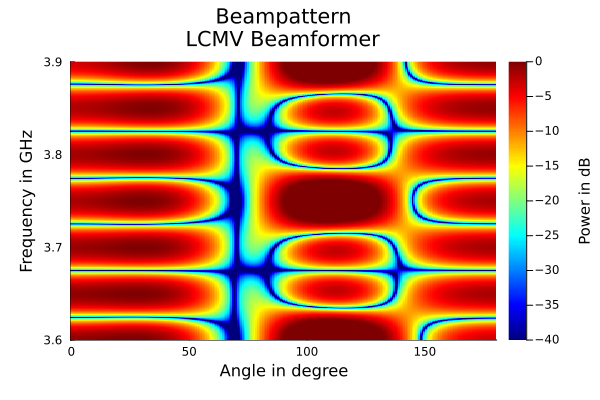

In [52]:
using ArraySignalProcessing
using CUDA
pa = TappedDelayLine(IsotropicArrayManifold(cu([-6e-2, -2e-2, 2e-2, 6e-2])), 4, 150e6)

# Use the array below to better see the behaviour
#pa = IsotropicArray(Vector(LinRange(-20e-2, 20e-2, 16)))

# Diagonal loading is applied by adding whitenoise to the correlation matrix
Snn = diffnoise(pa, 1e-6, 3.75e9) + whitenoise(pa, 1e-4)

# Constraints C set for two directions and 4 freqeuncy bands (as we set 4 taps)
C = steer(pa, cu(deg2rad.([30 70])), Float32.([3.6e9, 3.7e9, 3.8e9, 3.9e9]))
# Gains; four times repeated for the 4 frequencies
# the consstrains are set for
G = repeat([1, 0], 4, 1)

weights = lcmv_weights(cu(Snn), C, cu(G))
display(weights)

faxis = LinRange(3.6e9, 3.9e9, 1024)
ϕaxis = LinRange(0, 180, 256)
#A = steer.(Ref(pa), Ref(cu(collect(deg2rad.(ϕaxis)))), faxis)
#W = reduce(vcat, Ref(weights') .* A)
A = steer(pa, cu(deg2rad.(ϕaxis)), faxis)
W = transpose(reshape(weights' * A, :, length(faxis)))
WdB = 20*log10.(abs.(W))

using Plots
import Measures
p1 = heatmap(ϕaxis, faxis/1e9, Array(WdB), cmap = :jet, clim=(-40, 0))
plot!(title="Beampattern\nLCMV Beamformer", cbar_title="\nPower in dB", margin=5*Measures.mm)
xlabel!("Angle in degree")
ylabel!("Frequency in GHz")

display(p1)